In [8]:
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

con = duckdb.connect()

con.execute("INSTALL httpfs;")
con.execute("LOAD httpfs;")

con.execute("""
SET s3_region='us-east-1';
SET s3_use_ssl=true;
SET s3_url_style='path';
""")

con.execute("""
CREATE OR REPLACE VIEW animal_activity AS
SELECT *
FROM read_parquet(
  's3://jax-envision-public-data/study_1001/2025v3.3/tabular/*/*/animal_activity_db.parquet',
  hive_partitioning = true
)
""")


In [10]:
con.execute("DESCRIBE animal_activity").df()


,column_name,column_type,null,key,default,extra
0,predicted_identity,VARCHAR,YES,None,None,None
1,time,TIMESTAMP_NS,YES,None,None,None
2,resolution,BIGINT,YES,None,None,None
3,name,VARCHAR,YES,None,None,None
4,value,DOUBLE,YES,None,None,None
5,units,VARCHAR,YES,None,None,None
6,version_str,VARCHAR,YES,None,None,None
7,organization_id,BIGINT,YES,None,None,None
8,cage_id,BIGINT,YES,None,None,None
9,study_id,BIGINT,YES,None,None,None


In [12]:
con.execute("""
SELECT DISTINCT name
FROM animal_activity
""").df()


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,name
0,animal_bouts.climbing
1,animal_bouts.inactive
2,animal_bouts.active
3,animal_bouts.locomotion


In [28]:
# Replicate 1 - aggregate by animal and hour
df_rep1 = con.execute("""
SELECT 
    animal_id,
    cage_id,
    DATE_TRUNC('hour', time) AS hour,
    COUNT(*) AS locomotion_points,
    SUM(value) AS locomotion_seconds
FROM animal_activity
WHERE name = 'animal_bouts.locomotion'
AND cage_id BETWEEN 4917 AND 4925
GROUP BY animal_id, cage_id, DATE_TRUNC('hour', time)
ORDER BY animal_id, hour
""").df()

# Replicate 2 - aggregate by animal and hour
df_rep2 = con.execute("""
SELECT 
    animal_id,
    cage_id,
    DATE_TRUNC('hour', time) AS hour,
    COUNT(*) AS locomotion_points,
    SUM(value) AS locomotion_seconds
FROM animal_activity
WHERE name = 'animal_bouts.locomotion'
AND cage_id BETWEEN 4926 AND 4934
GROUP BY animal_id, cage_id, DATE_TRUNC('hour', time)
ORDER BY animal_id, hour
""").df()


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [30]:
import pandas as pd

def check_gaps(df, replicate_name):
    results = []
    for aid in df['animal_id'].unique():
        times = pd.date_range(df['hour'].min(), df['hour'].max(), freq='H')
        actual = df[df['animal_id'] == aid]['hour']
        missing = len(times.difference(actual))
        results.append((aid, missing))
    gaps_df = pd.DataFrame(results, columns=['animal_id', 'missing_hours'])
    print(f"=== {replicate_name} missing data per animal ===")
    print(gaps_df.sort_values('missing_hours', ascending=False))
    return gaps_df

gaps_rep1 = check_gaps(df_rep1, "Rep1")
gaps_rep2 = check_gaps(df_rep2, "Rep2")


=== Rep1 missing data per animal ===
    animal_id  missing_hours
6        9245             55
7        9246             55
8        9247             55
0        9239             10
1        9240             10
2        9241             10
3        9242             10
4        9243             10
5        9244             10
25       9282              9
24       9281              9
26       9283              9
11       9259              9
10       9258              9
9        9257              9
12       9260              8
14       9262              8
15       9263              8
16       9264              8
17       9265              8
13       9261              8
18       9275              7
19       9276              7
20       9277              7
21       9278              6
22       9279              6
23       9280              6
=== Rep2 missing data per animal ===
    animal_id  missing_hours
13       9270             25
14       9271             25
12       9269             2

/var/folders/bp/jv7_b5rd60j6_rlflqn6zd580000gn/T/ipykernel_28958/1100758080.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  times = pd.date_range(df['hour'].min(), df['hour'].max(), freq='H')
/var/folders/bp/jv7_b5rd60j6_rlflqn6zd580000gn/T/ipykernel_28958/1100758080.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  times = pd.date_range(df['hour'].min(), df['hour'].max(), freq='H')


/var/folders/bp/jv7_b5rd60j6_rlflqn6zd580000gn/T/ipykernel_28958/13736214.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([gaps_rep1['missing_hours'], gaps_rep2['missing_hours']], labels=["Rep1", "Rep2"])


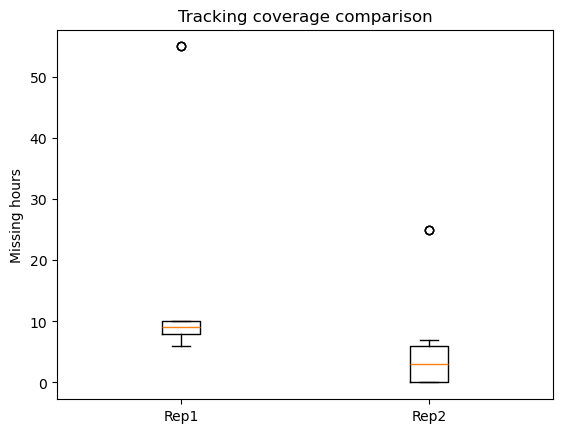

In [32]:
import matplotlib.pyplot as plt

plt.boxplot([gaps_rep1['missing_hours'], gaps_rep2['missing_hours']], labels=["Rep1", "Rep2"])
plt.ylabel("Missing hours")
plt.title("Tracking coverage comparison")
plt.show()


In [36]:
# Define official animal IDs per replicate
rep1_animals = [9239, 9240, 9241, 9242, 9243, 9244, 9245, 9246, 9247, 9257, 9258, 9259, 9260, 9261, 9262, 9263, 9264, 9265, 9275, 9276, 9277, 9278, 9279, 9280, 9281, 9282, 9283]
rep2_animals = [9248, 9249, 9250, 9251, 9252, 9253, 9254, 9255, 9256, 9266, 9267, 9268, 9269, 9270, 9271, 9272, 9273, 9274, 9284, 9285, 9286, 9287, 9288, 9289, 9290, 9291, 9292]

# Function to calculate missing hours per animal
def compute_missing_hours(animal_ids):
    query = f"""
    SELECT animal_id, time, value AS locomotion_seconds
    FROM animal_activity
    WHERE name = 'animal_bouts.locomotion'
    AND animal_id IN ({','.join(map(str, animal_ids))})
    """
    df = con.execute(query).df()
    
    # Convert time to datetime if needed
    df['time'] = pd.to_datetime(df['time'])
    df['hour'] = df['time'].dt.floor('H')
    
    # Count missing hours per animal
    expected_hours = df['hour'].nunique()  # total hours tracked
    missing_per_animal = []
    for aid in animal_ids:
        animal_hours = df[df['animal_id'] == aid]['hour'].nunique()
        missing_per_animal.append({'animal_id': aid, 'missing_hours': expected_hours - animal_hours})
    
    return pd.DataFrame(missing_per_animal)

# Run for Rep1 and Rep2
rep1_missing = compute_missing_hours(rep1_animals)
rep2_missing = compute_missing_hours(rep2_animals)

print("=== Rep1 missing data per animal ===")
print(rep1_missing.sort_values('missing_hours', ascending=False))

print("\n=== Rep2 missing data per animal ===")
print(rep2_missing.sort_values('missing_hours', ascending=False))


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

/var/folders/bp/jv7_b5rd60j6_rlflqn6zd580000gn/T/ipykernel_28958/3182210241.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['time'].dt.floor('H')


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

/var/folders/bp/jv7_b5rd60j6_rlflqn6zd580000gn/T/ipykernel_28958/3182210241.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['time'].dt.floor('H')


=== Rep1 missing data per animal ===
    animal_id  missing_hours
6        9245             49
7        9246             49
8        9247             49
0        9239              4
1        9240              4
2        9241              4
3        9242              4
4        9243              4
5        9244              4
25       9282              3
24       9281              3
26       9283              3
11       9259              3
10       9258              3
9        9257              3
12       9260              2
14       9262              2
15       9263              2
16       9264              2
17       9265              2
13       9261              2
18       9275              1
19       9276              1
20       9277              1
21       9278              0
22       9279              0
23       9280              0

=== Rep2 missing data per animal ===
    animal_id  missing_hours
13       9270             25
14       9271             25
12       9269             

In [42]:
def analyze_locomotion(df, rep_name):
    results = {}

    #  Missing hours per animal
    missing_hours = (
        df.groupby('animal_id')['locomotion_seconds']
          .apply(lambda x: (x.isna() | (x == 0)).sum() / 60)  # assuming 1 row per minute → convert to hours
          .reset_index(name='missing_hours')
          .sort_values('missing_hours', ascending=False)
    )
    results['missing_hours'] = missing_hours

    #  Average locomotion per animal
    avg_locomotion = (
        df.groupby('animal_id')['locomotion_seconds']
          .mean()
          .reset_index(name='avg_locomotion_seconds')
          .sort_values('avg_locomotion_seconds', ascending=False)
    )
    results['avg_locomotion'] = avg_locomotion

    # Detect unusually long inactivity periods per animal
    # Here we flag hours where locomotion_seconds == 0
    inactivity_periods = (
        df[df['locomotion_seconds'] == 0]
          .groupby('animal_id')['hour']
          .count()
          .reset_index(name='hours_inactive')
          .sort_values('hours_inactive', ascending=False)
    )
    results['inactivity_periods'] = inactivity_periods

    print(f"=== {rep_name} analysis ===")
    print("\nMissing hours:")
    print(missing_hours)
    print("\nAverage locomotion (seconds):")
    print(avg_locomotion)
    print("\nHours of inactivity (locomotion_seconds==0):")
    print(inactivity_periods)

    return results

# Example usage:
rep1_analysis = analyze_locomotion(df_rep1, "Rep1")
rep2_analysis = analyze_locomotion(df_rep2, "Rep2")


=== Rep1 analysis ===

Missing hours:
    animal_id  missing_hours
7        9246       0.150000
26       9283       0.116667
9        9257       0.083333
0        9239       0.083333
6        9245       0.066667
24       9281       0.066667
17       9265       0.066667
20       9277       0.050000
8        9247       0.050000
25       9282       0.050000
23       9280       0.050000
16       9264       0.050000
15       9263       0.033333
3        9242       0.033333
10       9258       0.033333
12       9260       0.033333
1        9240       0.033333
14       9262       0.033333
22       9279       0.016667
4        9243       0.016667
19       9276       0.016667
18       9275       0.016667
5        9244       0.016667
13       9261       0.016667
21       9278       0.000000
11       9259       0.000000
2        9241       0.000000

Average locomotion (seconds):
    animal_id  avg_locomotion_seconds
4        9243              370.621994
5        9244              364.966618
23   

In [44]:
import pandas as pd

def detect_weird_activity(df, rep_name):
    results = []

    # Ensure 'hour' exists
    if 'hour' not in df.columns:
        df['hour'] = df.index  # fallback if needed

    for animal in df['animal_id'].unique():
        df_animal = df[df['animal_id'] == animal].sort_values('hour')
        # Convert locomotion_seconds to boolean: 0 -> inactive
        inactive = (df_animal['locomotion_seconds'] == 0).astype(int)

        # Find consecutive zeros (streaks)
        streaks = []
        count = 0
        for val in inactive:
            if val == 1:
                count += 1
            else:
                if count > 0:
                    streaks.append(count)
                count = 0
        if count > 0:
            streaks.append(count)

        max_streak = max(streaks) if streaks else 0
        total_inactive_hours = inactive.sum()

        results.append({
            'animal_id': animal,
            'max_zero_streak_hours': max_streak,
            'total_inactive_hours': total_inactive_hours
        })

    df_results = pd.DataFrame(results).sort_values('max_zero_streak_hours', ascending=False)
    print(f"=== {rep_name} weird activity summary ===")
    print(df_results)
    return df_results

# Run on Rep1 and Rep2
weird_rep1 = detect_weird_activity(df_rep1, "Rep1")
weird_rep2 = detect_weird_activity(df_rep2, "Rep2")


=== Rep1 weird activity summary ===
    animal_id  max_zero_streak_hours  total_inactive_hours
10       9258                      2                     2
0        9239                      1                     5
14       9262                      1                     2
25       9282                      1                     3
24       9281                      1                     4
23       9280                      1                     3
22       9279                      1                     1
20       9277                      1                     3
19       9276                      1                     1
18       9275                      1                     1
17       9265                      1                     4
16       9264                      1                     3
15       9263                      1                     2
13       9261                      1                     1
1        9240                      1                     2
12       9260       

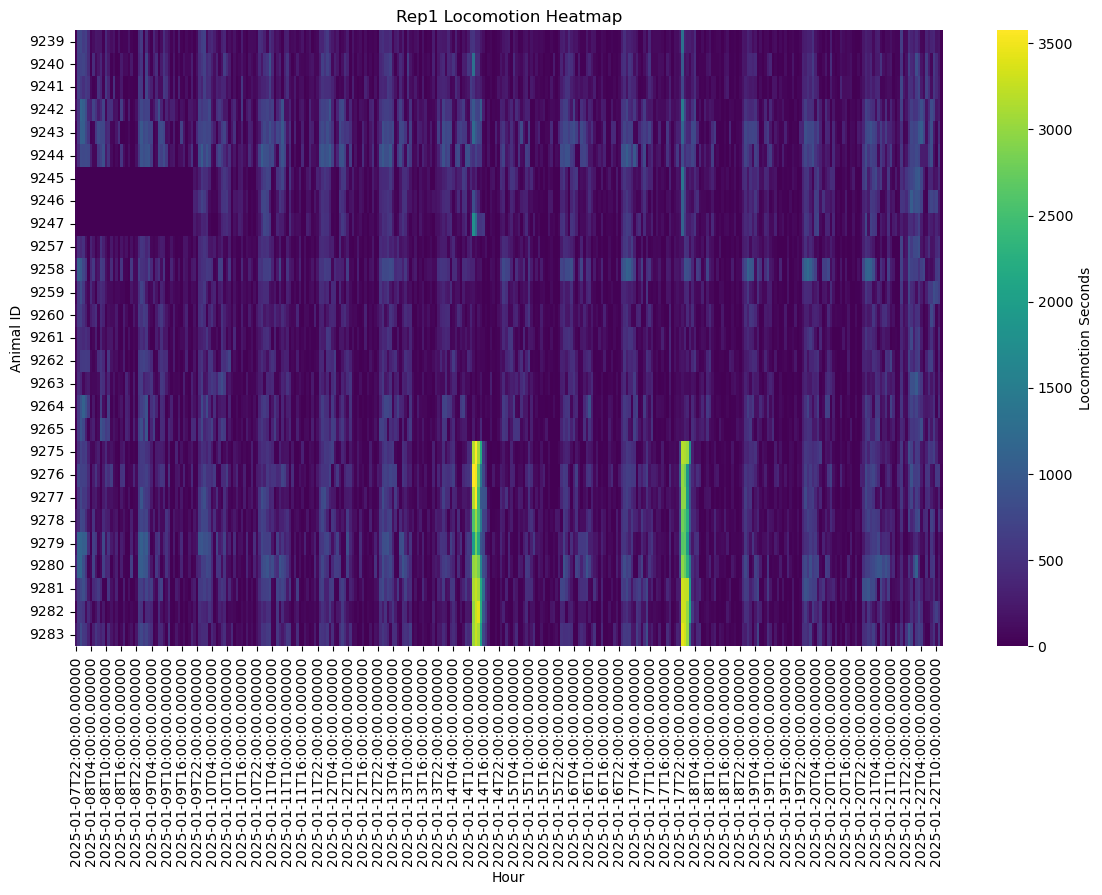

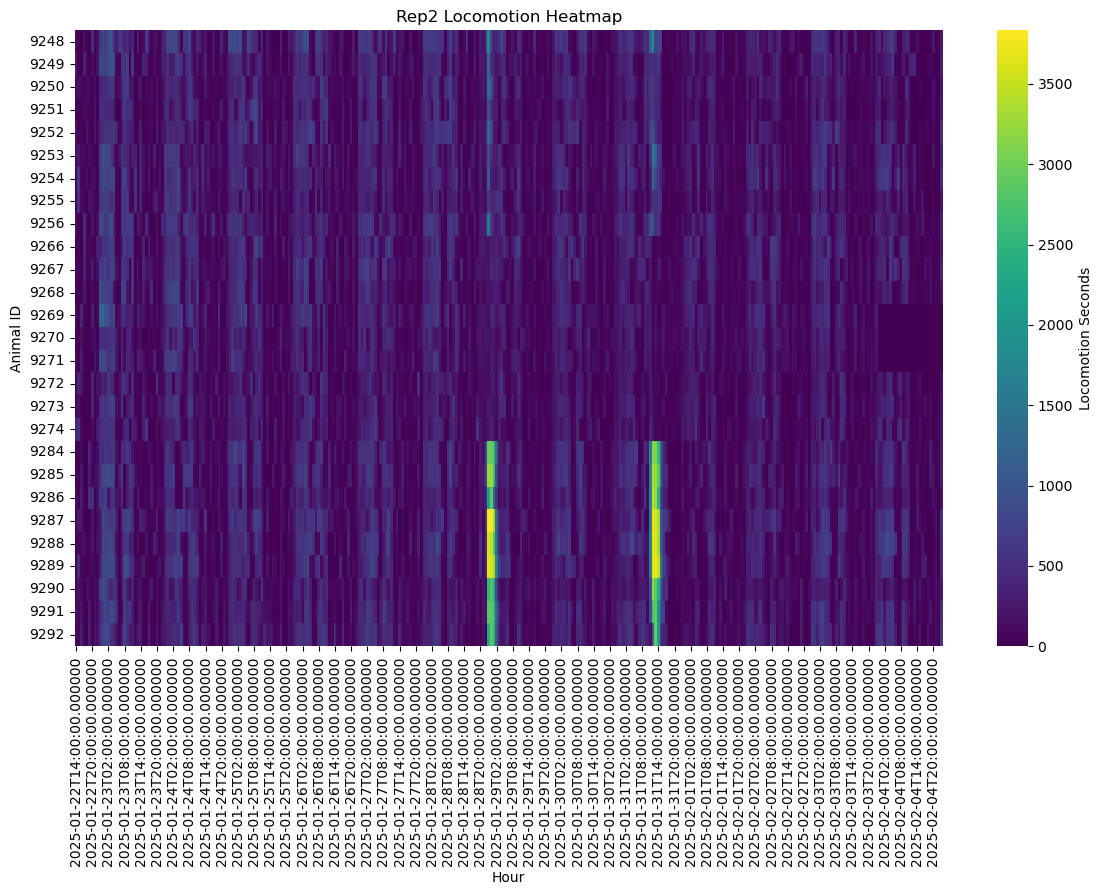

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_activity_heatmap(df, rep_name):
    pivot = df.pivot_table(
        index='animal_id', 
        columns='hour',
        values='locomotion_seconds',
        aggfunc='sum'
    ).fillna(0)

    plt.figure(figsize=(14,8))
    sns.heatmap(pivot, cmap='viridis', cbar_kws={'label': 'Locomotion Seconds'})
    plt.title(f'{rep_name} Locomotion Heatmap')
    plt.xlabel('Hour')
    plt.ylabel('Animal ID')
    plt.show()

plot_activity_heatmap(df_rep1, "Rep1")
plot_activity_heatmap(df_rep2, "Rep2")


=== Rep1 Cage Summary ===
   cage_id  avg_locomotion_seconds  total_inactive_hours  missing_hours
8     4925              228.748161              0.266667            0.0
7     4924              298.097758              0.233333            0.0
6     4923              220.738630              0.150000            0.0
0     4917              192.537129              0.116667            0.0
1     4918              222.169867              0.116667            0.0
2     4919              283.190778              0.083333            0.0
5     4922              188.095935              0.083333            0.0
3     4920              324.778454              0.066667            0.0
4     4921              345.209368              0.066667            0.0
=== Rep2 Cage Summary ===
   cage_id  avg_locomotion_seconds  total_inactive_hours  missing_hours
1     4927              256.417184              0.283333            0.0
0     4926              279.849269              0.233333            0.0
4     4930  

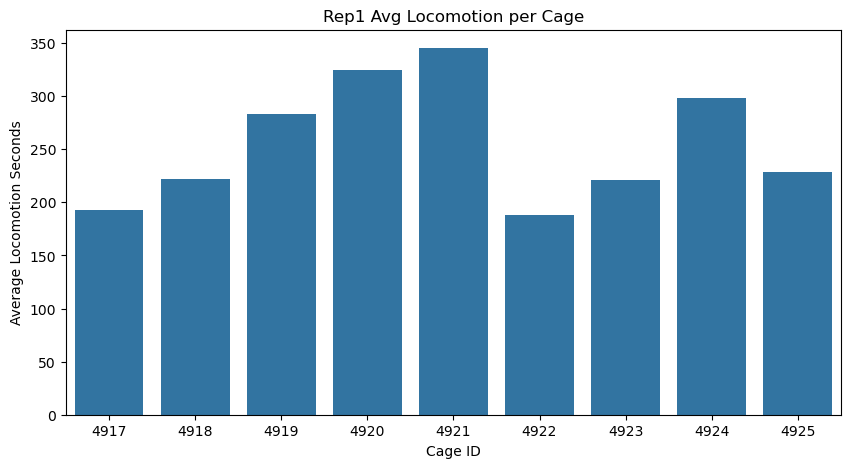

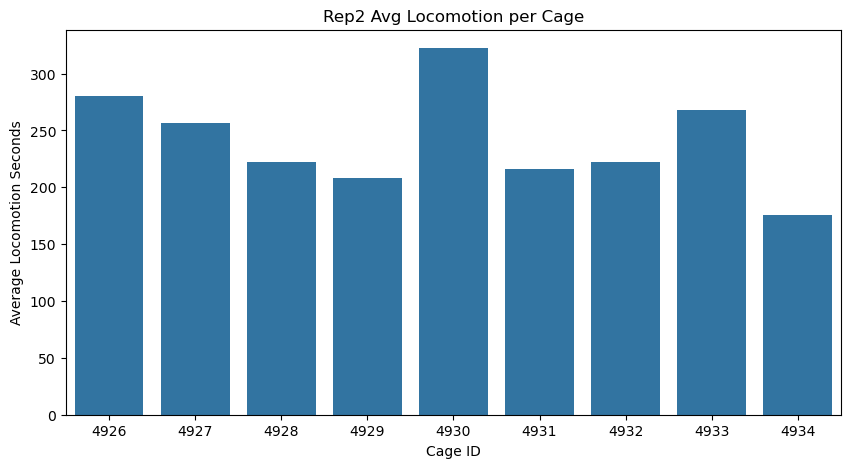

In [48]:
# Aggregate by cage
def cage_summary(df, rep_name):
    summary = df.groupby('cage_id').agg(
        avg_locomotion_seconds=('locomotion_seconds', 'mean'),
        total_inactive_hours=('locomotion_seconds', lambda x: (x==0).sum()/60),  # assuming 1 row per minute
        missing_hours=('locomotion_seconds', lambda x: x.isna().sum()/60)
    ).reset_index()
    
    print(f"=== {rep_name} Cage Summary ===")
    print(summary.sort_values('total_inactive_hours', ascending=False))
    return summary

rep1_cage_summary = cage_summary(df_rep1, "Rep1")
rep2_cage_summary = cage_summary(df_rep2, "Rep2")

# Optional: visualize cage-level locomotion
import seaborn as sns
import matplotlib.pyplot as plt

def plot_cage_activity(summary_df, rep_name):
    plt.figure(figsize=(10,5))
    sns.barplot(x='cage_id', y='avg_locomotion_seconds', data=summary_df)
    plt.title(f'{rep_name} Avg Locomotion per Cage')
    plt.ylabel('Average Locomotion Seconds')
    plt.xlabel('Cage ID')
    plt.show()

plot_cage_activity(rep1_cage_summary, "Rep1")
plot_cage_activity(rep2_cage_summary, "Rep2")


In [52]:
def flag_worst_tracked(df, rep_name):
    # Summarize per mouse
    mouse_summary = df.groupby('animal_id').agg(
        cage_id=('cage_id', 'first'),
        total_inactive_hours=('locomotion_seconds', lambda x: (x==0).sum()/60),  # assuming 1 row per min
        missing_hours=('locomotion_seconds', lambda x: x.isna().sum()/60),
        avg_locomotion_seconds=('locomotion_seconds', 'mean')
    ).reset_index()

    # Find worst-tracked per cage
    worst_per_cage = mouse_summary.groupby('cage_id').apply(
        lambda g: g.sort_values(['total_inactive_hours', 'missing_hours'], ascending=False).head(1)
    ).reset_index(drop=True)

    print(f"=== {rep_name} worst-tracked mice per cage ===")
    print(worst_per_cage[['animal_id', 'cage_id', 'total_inactive_hours', 'missing_hours', 'avg_locomotion_seconds']])
    return worst_per_cage

# Run for each replicate
worst_rep1 = flag_worst_tracked(df_rep1, "Rep1")
worst_rep2 = flag_worst_tracked(df_rep2, "Rep2")


=== Rep1 worst-tracked mice per cage ===
   animal_id  cage_id  total_inactive_hours  missing_hours  \
0       9239     4917              0.083333            0.0   
1       9257     4918              0.083333            0.0   
2       9277     4919              0.050000            0.0   
3       9280     4920              0.050000            0.0   
4       9242     4921              0.033333            0.0   
5       9260     4922              0.033333            0.0   
6       9265     4923              0.066667            0.0   
7       9283     4924              0.116667            0.0   
8       9246     4925              0.150000            0.0   

   avg_locomotion_seconds  
0              167.116862  
1              168.286891  
2              262.572481  
3              364.075411  
4              300.039492  
5              189.426385  
6              234.936249  
7              303.579873  
8              223.989752  
=== Rep2 worst-tracked mice per cage ===
   animal_id  cag

/var/folders/bp/jv7_b5rd60j6_rlflqn6zd580000gn/T/ipykernel_28958/2519456176.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  worst_per_cage = mouse_summary.groupby('cage_id').apply(
/var/folders/bp/jv7_b5rd60j6_rlflqn6zd580000gn/T/ipykernel_28958/2519456176.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  worst_per_cage = mouse_summary.groupby('cage_id').apply(


In [56]:
def analyze_tracking(df, rep_name):
    results = {}

    # 1️⃣ Create a numeric column for missing data (NaN or 0 locomotion)
    df['is_missing'] = (df['locomotion_seconds'].isna() | (df['locomotion_seconds']==0)).astype(int)

    # 2️⃣ Missing hours per animal
    missing_hours = (
        df.groupby('animal_id', as_index=False)['is_missing']
        .sum()
    )
    missing_hours['missing_hours'] = missing_hours['is_missing'] / 60  # minutes -> hours
    missing_hours = missing_hours.drop(columns='is_missing')
    results['missing_hours'] = missing_hours.sort_values('missing_hours', ascending=False)

    # 3️⃣ Average locomotion per animal
    avg_locomotion = (
        df.groupby('animal_id', as_index=False)['locomotion_seconds']
        .mean()
        .rename(columns={'locomotion_seconds':'avg_locomotion_seconds'})
    )
    results['avg_locomotion'] = avg_locomotion.sort_values('avg_locomotion_seconds', ascending=False)

    # 4️⃣ Total inactive hours per animal (locomotion_seconds == 0)
    inactive_hours = (
        df[df['locomotion_seconds']==0]
        .groupby('animal_id', as_index=False)['locomotion_seconds']
        .count()
    )
    inactive_hours['total_inactive_hours'] = inactive_hours['locomotion_seconds']/60
    inactive_hours = inactive_hours.drop(columns='locomotion_seconds')
    results['inactive_hours'] = inactive_hours.sort_values('total_inactive_hours', ascending=False)

    # 5️⃣ Max zero streaks per animal
    streaks = []
    for aid, group in df.groupby('animal_id'):
        zeros = (group['locomotion_seconds'] == 0).astype(int)
        max_streak = (zeros * (zeros.groupby((zeros != zeros.shift()).cumsum()).cumcount() + 1)).max()
        total_zeros = zeros.sum()
        streaks.append({'animal_id': aid, 'max_zero_streak_hours': max_streak/60, 'total_inactive_hours': total_zeros/60})
    streaks_df = pd.DataFrame(streaks)
    results['weird_activity'] = streaks_df.sort_values('max_zero_streak_hours', ascending=False)

    # 6️⃣ Cage summaries
    cage_summary = df.groupby('cage_id', as_index=False).agg(
        avg_locomotion_seconds=('locomotion_seconds','mean'),
        total_inactive_hours=('locomotion_seconds', lambda x: (x==0).sum()/60),
        missing_hours=('is_missing', lambda x: x.sum()/60)
    )
    results['cage_summary'] = cage_summary.sort_values('avg_locomotion_seconds', ascending=False)

    # 7️⃣ Worst-tracked mice per cage
    merged = df.merge(results['weird_activity'][['animal_id','total_inactive_hours']], on='animal_id', how='left')
    worst_per_cage = merged.groupby('cage_id', as_index=False).apply(lambda g: g.loc[g['total_inactive_hours'].idxmax()]).reset_index(drop=True)
    results['worst_tracked'] = worst_per_cage.sort_values('total_inactive_hours', ascending=False)

    print(f"=== {rep_name} analysis complete ===")
    return results

# Example usage:
rep1_results = analyze_tracking(df_rep1, "Rep1")
rep2_results = analyze_tracking(df_rep2, "Rep2")


=== Rep1 analysis complete ===
=== Rep2 analysis complete ===


/var/folders/bp/jv7_b5rd60j6_rlflqn6zd580000gn/T/ipykernel_28958/4054166803.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  worst_per_cage = merged.groupby('cage_id', as_index=False).apply(lambda g: g.loc[g['total_inactive_hours'].idxmax()]).reset_index(drop=True)
/var/folders/bp/jv7_b5rd60j6_rlflqn6zd580000gn/T/ipykernel_28958/4054166803.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  worst_per_c

In [58]:
# Missing hours per animal
print(rep1_results['missing_hours'].head(10))
print(rep2_results['missing_hours'].head(10))

# Average locomotion
print(rep1_results['avg_locomotion'].head(10))
print(rep2_results['avg_locomotion'].head(10))

# Total inactive hours
print(rep1_results['inactive_hours'].head(10))
print(rep2_results['inactive_hours'].head(10))

# Weird activity (max zero streaks)
print(rep1_results['weird_activity'].head(10))
print(rep2_results['weird_activity'].head(10))

# Cage summaries
print(rep1_results['cage_summary'])
print(rep2_results['cage_summary'])

# Worst-tracked mice per cage
print(rep1_results['worst_tracked'])
print(rep2_results['worst_tracked'])


    animal_id  missing_hours
7        9246       0.150000
26       9283       0.116667
9        9257       0.083333
0        9239       0.083333
6        9245       0.066667
24       9281       0.066667
17       9265       0.066667
20       9277       0.050000
8        9247       0.050000
25       9282       0.050000
    animal_id  missing_hours
0        9248       0.133333
18       9284       0.116667
8        9256       0.100000
26       9292       0.083333
23       9289       0.066667
21       9287       0.066667
19       9285       0.066667
15       9272       0.050000
1        9249       0.050000
22       9288       0.050000
    animal_id  avg_locomotion_seconds
4        9243              370.621994
5        9244              364.966618
23       9280              364.075411
24       9281              347.191910
19       9276              330.250921
10       9258              324.225146
22       9279              319.923382
26       9283              303.579873
3        9242       

In [66]:
import pandas as pd

def summarize_cages(df, rep_name):
    """
    Aggregate tracking data per cage and flag potential tracking issues.
    """
    # Aggregate per cage
    cage_summary = df.groupby('cage_id').agg(
        avg_locomotion_seconds=('locomotion_seconds', 'mean'),
        total_inactive_hours=('locomotion_seconds', lambda x: (x==0).sum()/60),  # assuming 1 row per minute
        missing_hours=('locomotion_seconds', lambda x: x.isna().sum()/60)
    ).reset_index()

    # Flag cages with suspiciously high inactivity or missing data
    cage_summary['flag_inactive'] = cage_summary['total_inactive_hours'] > cage_summary['total_inactive_hours'].mean() + 2*cage_summary['total_inactive_hours'].std()
    cage_summary['flag_missing'] = cage_summary['missing_hours'] > cage_summary['missing_hours'].mean() + 2*cage_summary['missing_hours'].std()

    cage_summary['replicate'] = rep_name
    return cage_summary

# Run summaries for Rep1 and Rep2
rep1_cage_summary = summarize_cages(df_rep1, "Rep1")
rep2_cage_summary = summarize_cages(df_rep2, "Rep2")

# Combine for comparison
all_cages_summary = pd.concat([rep1_cage_summary, rep2_cage_summary], ignore_index=True)

# Display
all_cages_summary.sort_values(['replicate', 'cage_id'], inplace=True)
print(all_cages_summary)


    cage_id  avg_locomotion_seconds  total_inactive_hours  missing_hours  \
0      4917              192.537129              0.116667            0.0   
1      4918              222.169867              0.116667            0.0   
2      4919              283.190778              0.083333            0.0   
3      4920              324.778454              0.066667            0.0   
4      4921              345.209368              0.066667            0.0   
5      4922              188.095935              0.083333            0.0   
6      4923              220.738630              0.150000            0.0   
7      4924              298.097758              0.233333            0.0   
8      4925              228.748161              0.266667            0.0   
9      4926              279.849269              0.233333            0.0   
10     4927              256.417184              0.283333            0.0   
11     4928              222.454796              0.033333            0.0   
12     4929 

In [68]:
# Combine Rep1 and Rep2 per-animal summaries
rep1_animals = df_rep1.groupby('animal_id')['locomotion_seconds'].apply(
    lambda x: ((x==0) | x.isna()).sum()/60  # total inactive hours
).reset_index(name='total_inactive_hours_rep1')

rep2_animals = df_rep2.groupby('animal_id')['locomotion_seconds'].apply(
    lambda x: ((x==0) | x.isna()).sum()/60
).reset_index(name='total_inactive_hours_rep2')

# Merge
animal_compare = rep1_animals.merge(rep2_animals, on='animal_id', how='outer')
 
# Compute difference between reps
animal_compare['inactive_diff'] = abs(animal_compare['total_inactive_hours_rep1'] - 
                                     animal_compare['total_inactive_hours_rep2'])

# Sort by max inactivity or difference
top_anomalous = animal_compare.sort_values(
    ['total_inactive_hours_rep1', 'total_inactive_hours_rep2', 'inactive_diff'], 
    ascending=False
)

top_anomalous.head(10)


,animal_id,total_inactive_hours_rep1,total_inactive_hours_rep2,inactive_diff
7,9246,0.150000,NaN,NaN
44,9283,0.116667,NaN,NaN
0,9239,0.083333,NaN,NaN
18,9257,0.083333,NaN,NaN
6,9245,0.066667,NaN,NaN
26,9265,0.066667,NaN,NaN
42,9281,0.066667,NaN,NaN
8,9247,0.050000,NaN,NaN
25,9264,0.050000,NaN,NaN
38,9277,0.050000,NaN,NaN


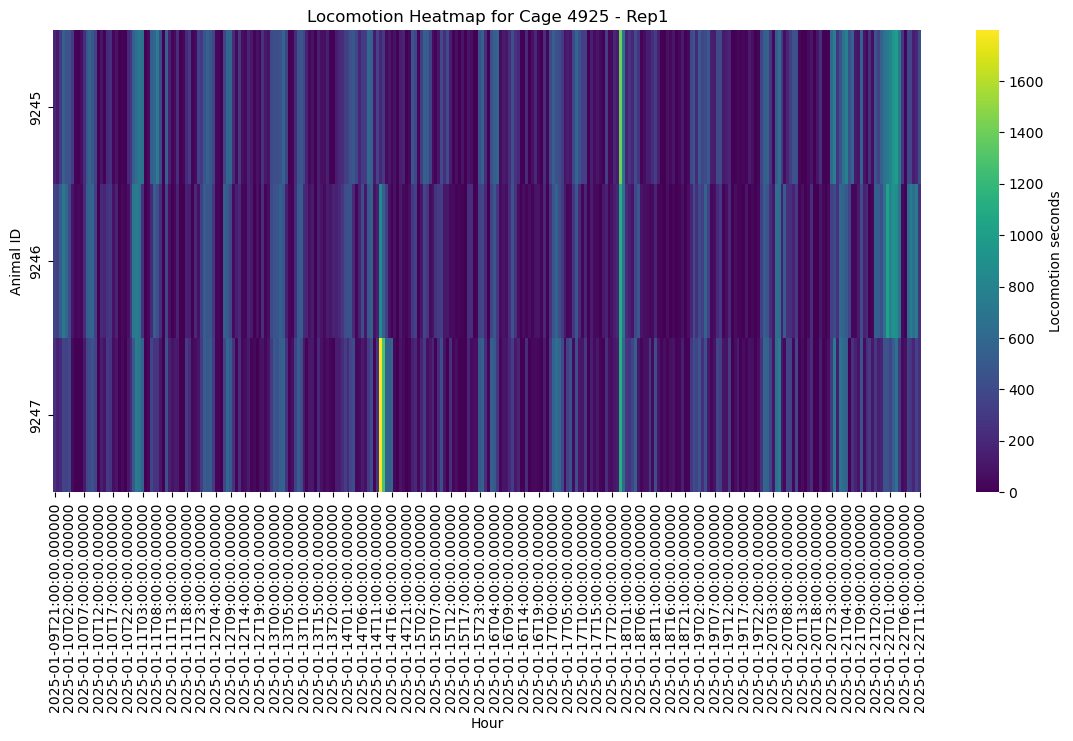

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example for one cage in Rep1
cage_id = 4925
cage_data = df_rep1[df_rep1['cage_id']==cage_id].copy()
pivot = cage_data.pivot_table(
    index='animal_id', 
    columns='hour', 
    values='locomotion_seconds', 
    aggfunc='sum'
)

plt.figure(figsize=(14,6))
sns.heatmap(pivot, cmap='viridis', cbar_kws={'label':'Locomotion seconds'})
plt.title(f'Locomotion Heatmap for Cage {cage_id} - Rep1')
plt.xlabel('Hour')
plt.ylabel('Animal ID')
plt.show()


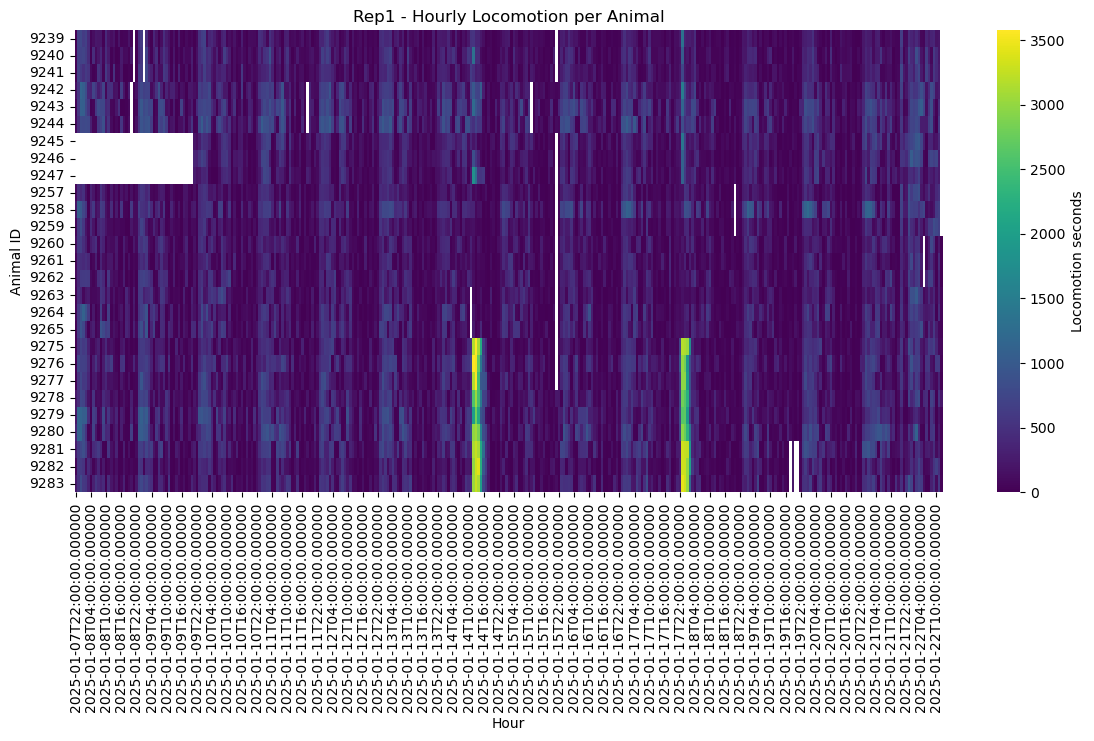

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example for Rep1
pivot_rep1 = df_rep1.pivot_table(
    index='animal_id', 
    columns='hour', 
    values='locomotion_seconds', 
    aggfunc='max'
)

plt.figure(figsize=(14,6))
sns.heatmap(pivot_rep1, cmap='viridis', cbar_kws={'label': 'Locomotion seconds'})
plt.title("Rep1 - Hourly Locomotion per Animal")
plt.xlabel("Hour")
plt.ylabel("Animal ID")
plt.show()


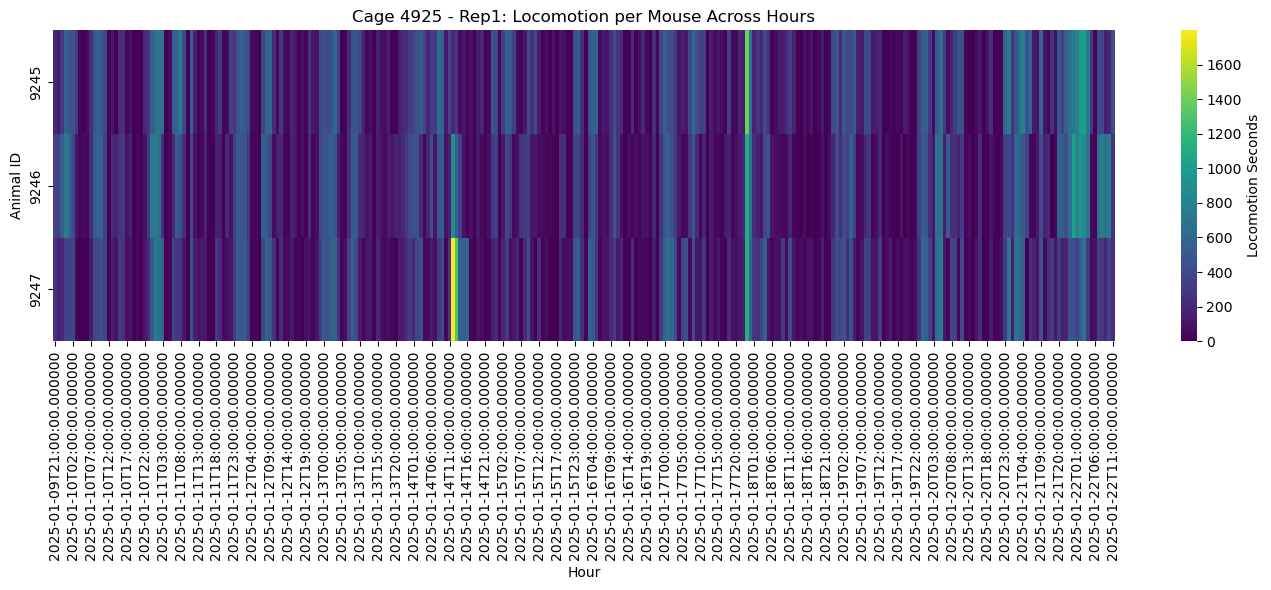

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter data for Cage 4925 in Rep1
cage_id = 4925
cage_data = df_rep1[df_rep1['cage_id'] == cage_id].copy()

# Pivot table: rows = animal_id, columns = hour, values = locomotion_seconds
pivot = cage_data.pivot_table(
    index='animal_id',
    columns='hour',
    values='locomotion_seconds',
    aggfunc='sum'  # sum in case there are multiple measurements per hour
).fillna(0)  # fill missing hours with 0

# Plot heatmap
plt.figure(figsize=(14,6))
sns.heatmap(pivot, cmap='viridis', cbar_kws={'label':'Locomotion Seconds'})
plt.title(f'Cage {cage_id} - Rep1: Locomotion per Mouse Across Hours')
plt.xlabel('Hour')
plt.ylabel('Animal ID')
plt.tight_layout()
plt.show()


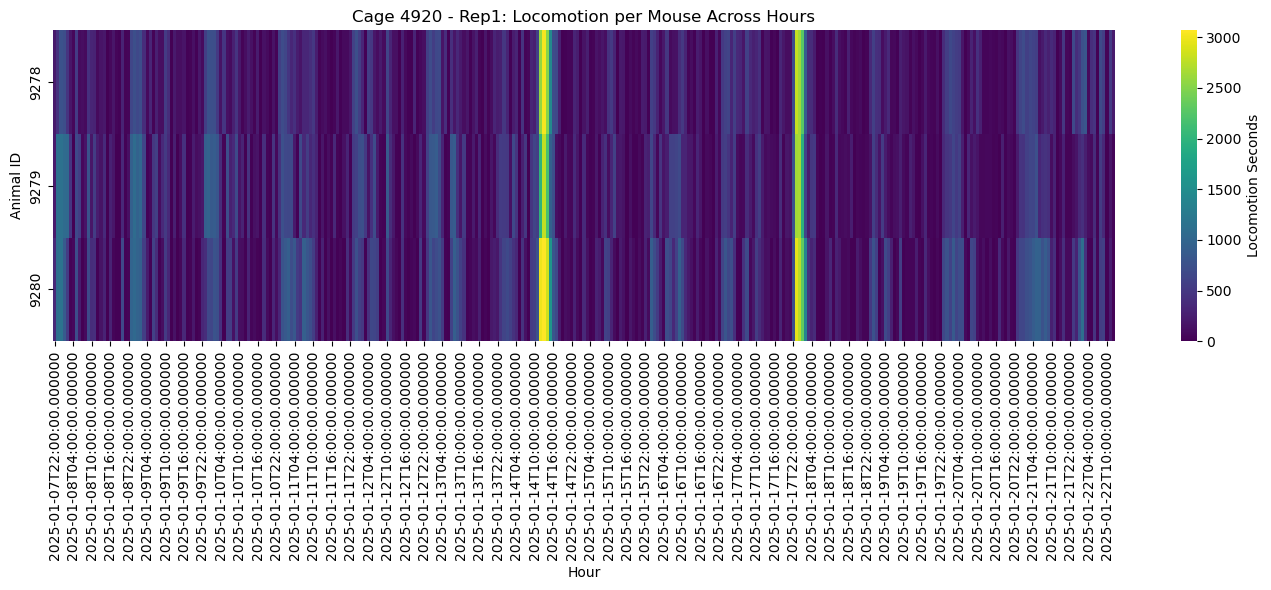

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter data for Cage 4925 in Rep1
cage_id = 4920
cage_data = df_rep1[df_rep1['cage_id'] == cage_id].copy()

# Pivot table: rows = animal_id, columns = hour, values = locomotion_seconds
pivot = cage_data.pivot_table(
    index='animal_id',
    columns='hour',
    values='locomotion_seconds',
    aggfunc='sum'  # sum in case there are multiple measurements per hour
).fillna(0)  # fill missing hours with 0

# Plot heatmap
plt.figure(figsize=(14,6))
sns.heatmap(pivot, cmap='viridis', cbar_kws={'label':'Locomotion Seconds'})
plt.title(f'Cage {cage_id} - Rep1: Locomotion per Mouse Across Hours')
plt.xlabel('Hour')
plt.ylabel('Animal ID')
plt.tight_layout()
plt.show()
